# GENAI Project
# Aarib Ahmed Vahidy 22K-4004

This project implements a Deep Convolutional Generative Adversarial Network (DCGAN) trained to generate 64×64 anime faces. The model is trained on a curated dataset of 21,551 manually cropped and resized anime face images, allowing the generator to learn core visual patterns such as eye shape, hair style, color palettes, and facial proportions.

The system consists of:

A Generator that transforms random noise vectors into 64×64 RGB anime-style faces using transposed convolutions, batch normalization, and ReLU activations.

A Discriminator that distinguishes real anime faces from generated ones using strided convolutions and LeakyReLU activations.

Both networks are trained in an adversarial setup using the Adam optimizer and standard DCGAN training heuristics. After around 50 epochs, the generator becomes capable of producing high-quality, aesthetically coherent anime faces with diverse styles.

This notebook walks through dataset loading, model architecture, training loops, and generating new samples, enabling anyone to understand, reproduce, and extend the DCGAN-based anime face generator.

In [1]:
!pip install opendatasets --upgrade --quiet

import opendatasets as od
import os

dataset_url = 'https://www.kaggle.com/datasets/soumikrakshit/anime-faces'
od.download(dataset_url)

# Define data directory
DATA_DIR = './anime-faces'
print(f"Dataset contents: {os.listdir(DATA_DIR)}")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aaribvahidy
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/anime-faces


100%|██████████| 441M/441M [00:03<00:00, 153MB/s]



Dataset contents: ['data']


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Configuration
image_size = 64
batch_size = 128
latent_size = 128 # Size of the random noise vector
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Mean and Std for normalization

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


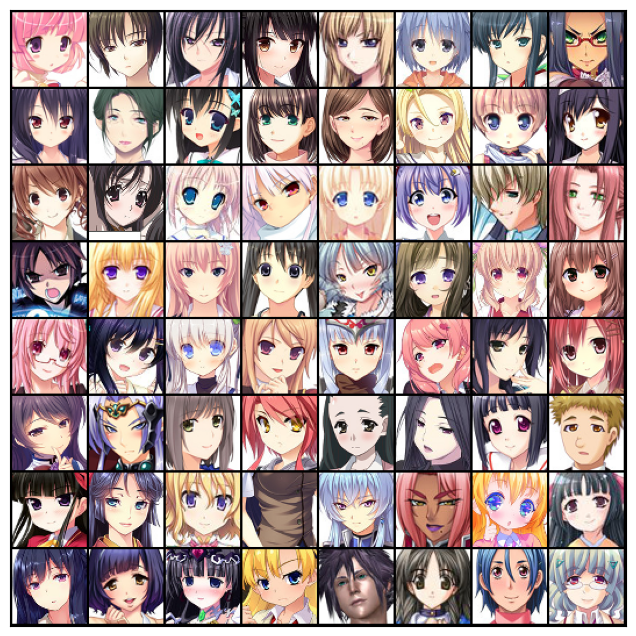

In [3]:
# Create the dataset with required transformations
train_ds = dsets.ImageFolder(DATA_DIR, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
]))

# Create Data Loader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Helper function to denormalize and view images
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

# Show a sample batch
show_batch(train_dl)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # State size: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State size: 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State size: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State size: 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Final Output: 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Move model to GPU
generator = Generator().to(device)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: 64 x 32 x 32

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: 128 x 16 x 16

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: 256 x 8 x 8

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: 512 x 4 x 4

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 (Probability of being real)
        )

    def forward(self, input):
        return self.main(input)

# Move model to GPU
discriminator = Discriminator().to(device)

In [6]:
# Loss function and Optimizers
criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

# Directory to save results
import os
os.makedirs('generated_images', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [7]:
from torchvision.utils import save_image

# Number of epochs
epochs = 50

# Fixed noise to visualize progress consistently
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

print("Starting Training Loop...")

for epoch in range(epochs):
    for i, data in enumerate(train_dl, 0):

        # ---------------------
        #  1. Train Discriminator
        # ---------------------
        discriminator.zero_grad()

        # Train with Real Images
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1.0, device=device) # Label 1 for real

        output = discriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Train with Fake Images
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(0.0) # Label 0 for fake

        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()

        errD = errD_real + errD_fake
        optimizerD.step()

        # -----------------
        #  2. Train Generator
        # -----------------
        generator.zero_grad()
        label.fill_(1.0) # Generator wants Discriminator to think these are real (Label 1)

        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    # Stats and visualization every epoch
    print(f'[{epoch+1}/{epochs}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}')

    # Save sample image
    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
        save_image(denorm(fake), f'generated_images/epoch_{epoch+1}.png')

print("Training Finished!")

Starting Training Loop...
[1/50] Loss_D: 1.0327 Loss_G: 7.3590
[2/50] Loss_D: 0.3834 Loss_G: 3.4661
[3/50] Loss_D: 0.5235 Loss_G: 5.7718
[4/50] Loss_D: 0.3226 Loss_G: 4.8247
[5/50] Loss_D: 0.6633 Loss_G: 7.6563
[6/50] Loss_D: 0.4751 Loss_G: 7.0204
[7/50] Loss_D: 0.2615 Loss_G: 6.6335
[8/50] Loss_D: 0.3692 Loss_G: 3.9326
[9/50] Loss_D: 0.6171 Loss_G: 8.6610
[10/50] Loss_D: 0.4167 Loss_G: 7.5515
[11/50] Loss_D: 0.1895 Loss_G: 4.5019
[12/50] Loss_D: 0.1919 Loss_G: 3.3373
[13/50] Loss_D: 0.7315 Loss_G: 10.3409
[14/50] Loss_D: 1.8451 Loss_G: 4.1552
[15/50] Loss_D: 0.3930 Loss_G: 6.9787
[16/50] Loss_D: 0.1942 Loss_G: 4.3395
[17/50] Loss_D: 0.3058 Loss_G: 7.2807
[18/50] Loss_D: 0.1588 Loss_G: 4.8139
[19/50] Loss_D: 0.1160 Loss_G: 4.4428
[20/50] Loss_D: 0.3902 Loss_G: 2.0154
[21/50] Loss_D: 0.2165 Loss_G: 4.3343
[22/50] Loss_D: 0.3779 Loss_G: 8.0084
[23/50] Loss_D: 0.1186 Loss_G: 5.9502
[24/50] Loss_D: 0.1091 Loss_G: 5.0271
[25/50] Loss_D: 0.1544 Loss_G: 5.0654
[26/50] Loss_D: 0.0682 Loss_G: 3

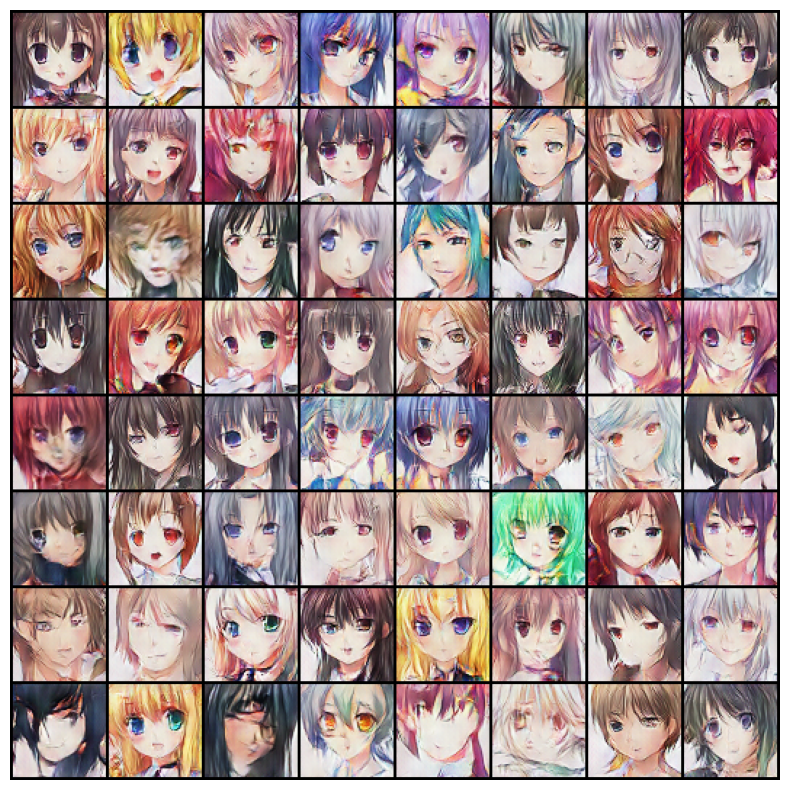

Models saved successfully.


In [8]:
# Display the last generated image grid
import matplotlib.image as mpimg

img = mpimg.imread(f'generated_images/epoch_{epochs}.png')
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

# Save the model
torch.save(generator.state_dict(), 'models/anime_generator.pth')
torch.save(discriminator.state_dict(), 'models/anime_discriminator.pth')
print("Models saved successfully.")

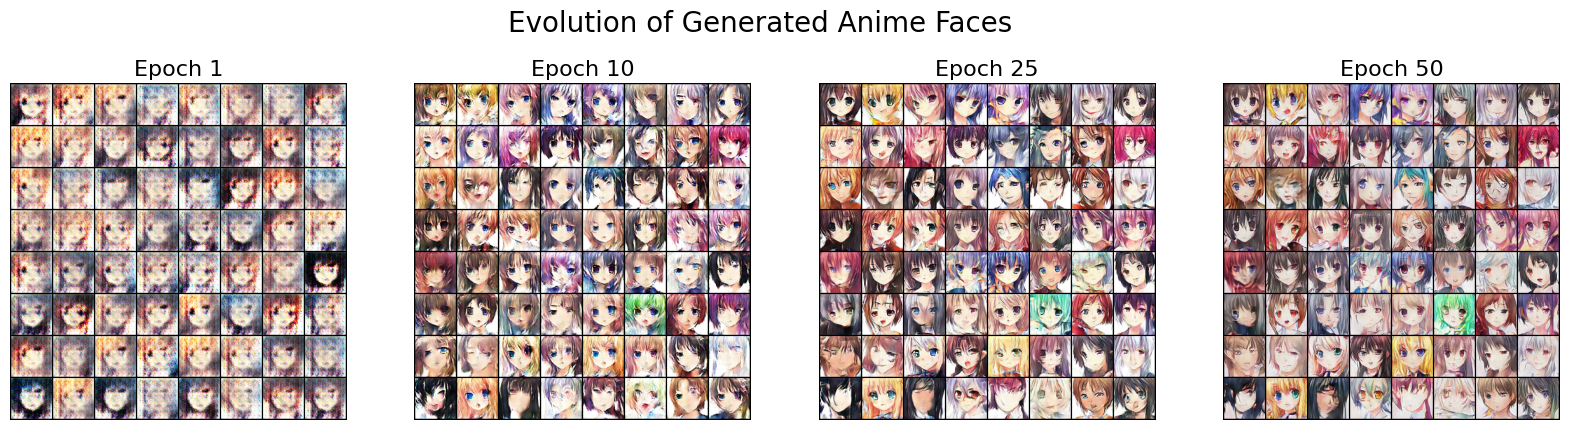

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

milestones = [1, 10, 25, 50]

fig, axes = plt.subplots(1, len(milestones), figsize=(20, 5))

for i, epoch in enumerate(milestones):
    img_path = f'generated_images/epoch_{epoch}.png'
    try:
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Epoch {epoch}', fontsize=16)
        axes[i].axis('off')
    except FileNotFoundError:
        print(f"Could not find image for Epoch {epoch}")

plt.suptitle("Evolution of Generated Anime Faces", fontsize=20)
plt.show()

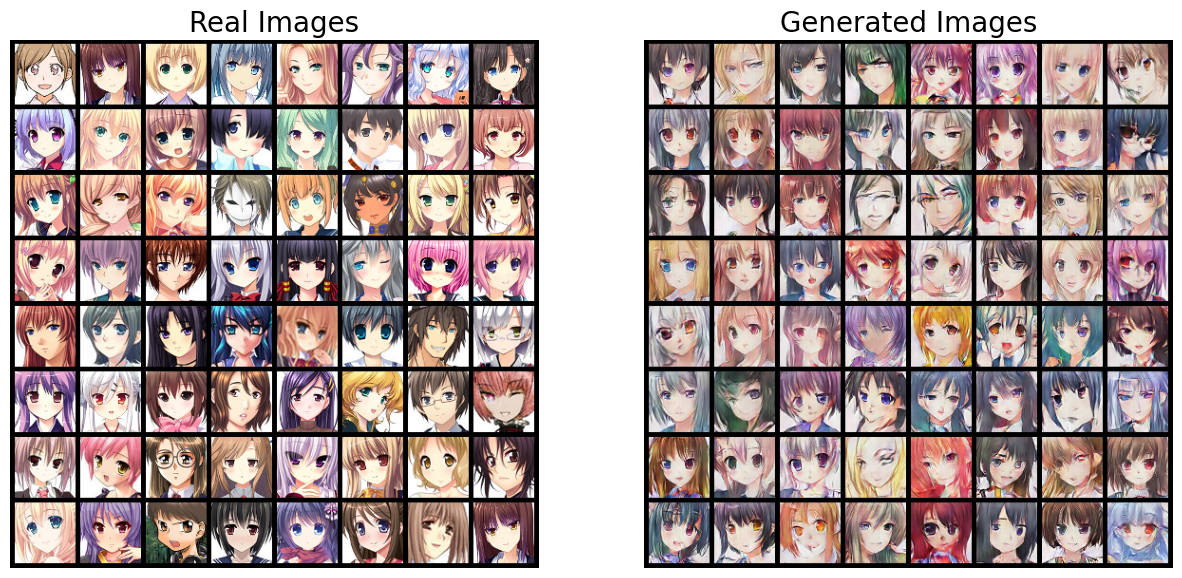

In [10]:
# 1. Get a batch of real images
real_batch = next(iter(train_dl))
real_images = real_batch[0].to(device)[:64] # Take first 64

# 2. Generate a batch of fake images
noise = torch.randn(64, latent_size, 1, 1, device=device)
fake_images = generator(noise)

# 3. Plot them side by side
plt.figure(figsize=(15, 15))

# Plot Real Images
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images", fontsize=20)
plt.imshow(np.transpose(make_grid(real_images, padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot Fake Images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Generated Images", fontsize=20)
plt.imshow(np.transpose(make_grid(fake_images, padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.show()

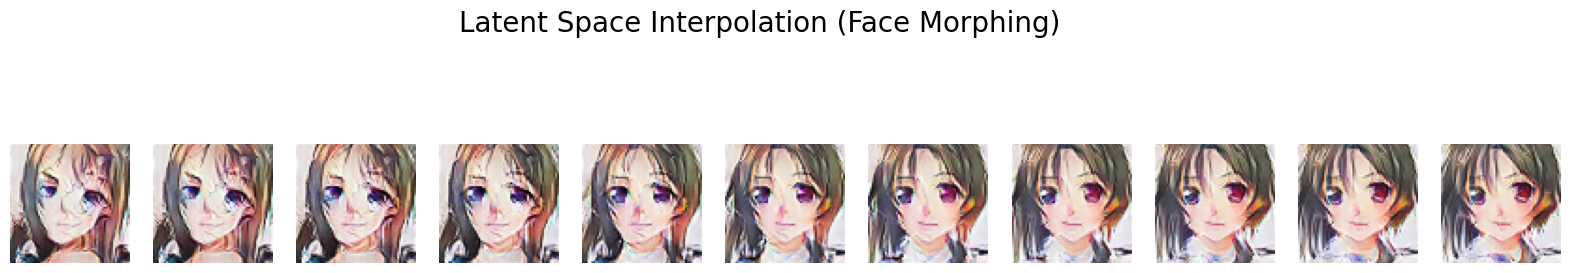

In [11]:
# Generate two random latent vectors
z1 = torch.randn(1, latent_size, 1, 1, device=device)
z2 = torch.randn(1, latent_size, 1, 1, device=device)

# Create 10 intermediate steps between z1 and z2
steps = 10
interpolated_images = []

for i in range(steps + 1):
    alpha = i / steps
    # Linear interpolation formula: z = (1-alpha)*z1 + alpha*z2
    z_interp = (1 - alpha) * z1 + alpha * z2
    with torch.no_grad():
        img = generator(z_interp).cpu()
        interpolated_images.append(denorm(img).squeeze(0)) # Remove batch dim

# Plot the morphing sequence
fig, axes = plt.subplots(1, steps + 1, figsize=(20, 4))
for i, img in enumerate(interpolated_images):
    axes[i].imshow(img.permute(1, 2, 0).numpy()) # Convert to HWC for matplotlib
    axes[i].axis('off')

plt.suptitle("Latent Space Interpolation (Face Morphing)", fontsize=20)
plt.show()

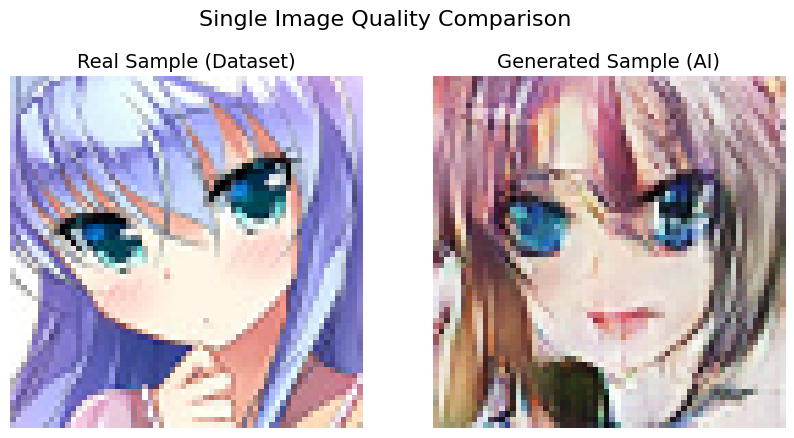

In [12]:
import matplotlib.pyplot as plt

# 1. Fetch a single real image
# We grab a batch and just take the first one (index 0)
real_batch = next(iter(train_dl))
real_single_img = real_batch[0][0].to(device)

# 2. Generate a single fake image
# We use a batch size of 1 for the noise vector
random_noise = torch.randn(1, latent_size, 1, 1, device=device)
fake_single_img = generator(random_noise).detach().squeeze(0) # Remove batch dimension

# 3. Plot them side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display Real Image
# We must move to CPU, denormalize, and reorder dimensions (C,H,W -> H,W,C) for Matplotlib
axes[0].imshow(denorm(real_single_img).cpu().permute(1, 2, 0).clip(0, 1))
axes[0].set_title("Real Sample (Dataset)", fontsize=14)
axes[0].axis('off')

# Display Generated Image
axes[1].imshow(denorm(fake_single_img).cpu().permute(1, 2, 0).clip(0, 1))
axes[1].set_title("Generated Sample (AI)", fontsize=14)
axes[1].axis('off')

plt.suptitle("Single Image Quality Comparison", fontsize=16)
plt.show()